# Setup and Data Preprocessing

In [1]:
import os
!pwd
os.chdir('/content/drive/MyDrive/Delhi/')

/content


In [2]:
!pwd

/content/drive/MyDrive/Delhi


In [3]:
# !git clone https://github.com/IDEA-Research/DINO.git

In [4]:
os.chdir("./DINO/")
!pwd

/content/drive/MyDrive/Delhi/DINO


In [5]:
!pip install -r requirements.txt
!pip install yapf==0.40.1

  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-install-2fdxhe6p/pycocotools_0ef579ecbb3c41a7a5a4c753aea5ac64
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-install-2fdxhe6p/pycocotools_0ef579ecbb3c41a7a5a4c753aea5ac64
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-install-2fdxhe6p/panopticapi_93200be0424744ad8e4d7340c0f1b213
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/panopticapi.git /tmp/pip-install-2fdxhe6p/panopticapi_93200be0424744ad8e4d7340c0f1b213
  Resolved https://github.com/cocodataset/panopticapi.git to commit 7bb4655548f98f3fedc07bf37e9040a992b054b0
  Preparing metadata (setup.py) ... done


In [6]:
!cd models/dino/ops && python setup.py build install && cd ../../..

running build
running build_py
running build_ext
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:502: UserWarning: Attempted to use ninja as the BuildExtension backend but we could not find ninja.. Falling back to using the slow distutils backend.
  warnings.warn(msg.format('we could not find ninja.'))
/usr/local/lib/python3.10/dist-packages/torch/utils/cpp_extension.py:424: UserWarning: There are no x86_64-linux-gnu-g++ version bounds defined for CUDA version 11.8
  warnings.warn(f'There are no {compiler_name} version bounds defined for CUDA version {cuda_str_version}')
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

    

In [7]:
os.chdir("models/dino/ops/")

In [8]:
!pip3 install .

Processing /content/drive/MyDrive/Delhi/DINO/models/dino/ops
  Preparing metadata (setup.py) ... done
  Created wheel for MultiScaleDeformableAttention: filename=MultiScaleDeformableAttention-1.0-cp310-cp310-linux_x86_64.whl size=2791508 sha256=468c057abc59f75fd9f0065e4683ade77a7a63f5caf613730ff5f5ca59db625b
  Stored in directory: /tmp/pip-ephem-wheel-cache-t90wgeqj/wheels/48/2b/36/1d47834b88e7a9477a30a8dd106f50eb0fde3533a6ae90be20
Successfully built MultiScaleDeformableAttention
  Attempting uninstall: MultiScaleDeformableAttention
    Found existing installation: MultiScaleDeformableAttention 1.0
    Uninstalling MultiScaleDeformableAttention-1.0:
      Successfully uninstalled MultiScaleDeformableAttention-1.0


In [9]:
!pip install xmltodict

# Model Pipeline for DINO

In [10]:
os.chdir('/content/drive/MyDrive/Delhi/DINO')
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

In [11]:
model_config_path = "/content/drive/MyDrive/Delhi/DINO/config/DINO/DINO_4scale.py" # change the path of the model config file
model_checkpoint_path = "/content/drive/MyDrive/Delhi/checkpoints/checkpoint0033_4scale.pth" # change the path of the model checkpoint

args = SLConfig.fromfile(model_config_path)
args.device = 'cuda'
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [12]:
os.chdir('/content/drive/MyDrive/Delhi/dino_dataset/valid/')
import xmltodict
import json

def create_targetjson(xmlfiles):
    idx = 0
    cat_idx = 0
    annot_idx = 0
    licenses = [{
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License"
        }]
    images = []
    annots = []
    categories = []
    unique_cat = set()
    for file in xmlfiles:
        with open(file, 'r') as xml_file:
            xml_content = xml_file.read()
        xml_dict = xmltodict.parse(xml_content)
        image_id = idx + 1
        idx += 1
        images.append({
            "license": 1,
            "file_name": file.replace(".xml",".png"),
            "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
            "height": xml_dict['annotation']['size']['height'],
            "width": xml_dict['annotation']['size']['width'],
            "date_captured": "2013-11-14 17:02:52",
            "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
            "id": image_id
        })
        # breakpoint()
        for key, value in xml_dict['annotation'].items():
            if key == "object":
                for val in value:
                    if val["name"] not in unique_cat:
                        unique_cat.add(val["name"])
                        categories.append({
                            "supercategory": val["name"],
                            "id": cat_idx + 1,
                            "name": val["name"],
                            "keypoints": [],
                            "skeleton": []
                        })
                        cat_idx += 1
                    width = int(val["bndbox"]["xmax"]) - int(val["bndbox"]["xmin"])
                    height = int(val["bndbox"]["ymax"]) - int(val["bndbox"]["ymin"])
                    annots.append({
                        "segmentation": [],
                        "num_keypoints": 0,
                        "area": 0,
                        "iscrowd": 0,
                        "keypoints":[],
                        "image_id": image_id,
                        "bbox": [int(val["bndbox"]["xmin"]),int(val["bndbox"]["ymin"]), width, height],
                        "category_id": 1,
                        "id": annot_idx + 1
                    })
                    annot_idx += 1
    target_data = {"info": {
            "description": "COCO 2017 Dataset",
            "url": "http://cocodataset.org",
            "version": "1.0",
            "year": 2017,
            "contributor": "COCO Consortium",
            "date_created": "2017/09/01"
        }, "licenses":licenses, "images":images, "annotations":annots, "categories":categories}
    print(f"unique cat {unique_cat}")
    return target_data

In [13]:
current_directory = os.getcwd()
files_in_directory = os.listdir(current_directory)
xml_files = [file for file in files_in_directory if file.endswith('.xml')]
target_data = create_targetjson(xml_files)
with open("target.json",'w') as fi:
    json.dump(target_data,fi)
# target_data

unique cat {'pedestrian'}


In [14]:
!pwd

/content/drive/MyDrive/Delhi/dino_dataset/valid


# Visualizing Input Bounding Boxes

In [15]:
os.chdir('/content/drive/MyDrive/Delhi/DINO')
args.dataset_file = 'delhi'
args.coco_path = "/content/drive/MyDrive/Delhi/dino_dataset/" # the path of coco
args.fix_size = False
dataset_val = build_dataset(image_set='val', args=args)

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [16]:
image, targets = dataset_val[0]

In [17]:
image.shape

torch.Size([3, 800, 1066])

In [18]:
targets

{'boxes': tensor([[0.4211, 0.4781, 0.0391, 0.1187],
         [0.6422, 0.5604, 0.0781, 0.3208],
         [0.4836, 0.6552, 0.1453, 0.6271]]),
 'labels': tensor([1, 1, 1]),
 'image_id': tensor([1]),
 'keypoints': tensor([], size=(3, 0, 3)),
 'area': tensor([0., 0., 0.]),
 'iscrowd': tensor([0, 0, 0]),
 'orig_size': tensor([480, 640]),
 'size': tensor([ 800, 1066])}

In [19]:
# load coco names
with open('util/coco_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}
# id2name = {1: 'Pedestrian'}

Image id is:  tensor([1])


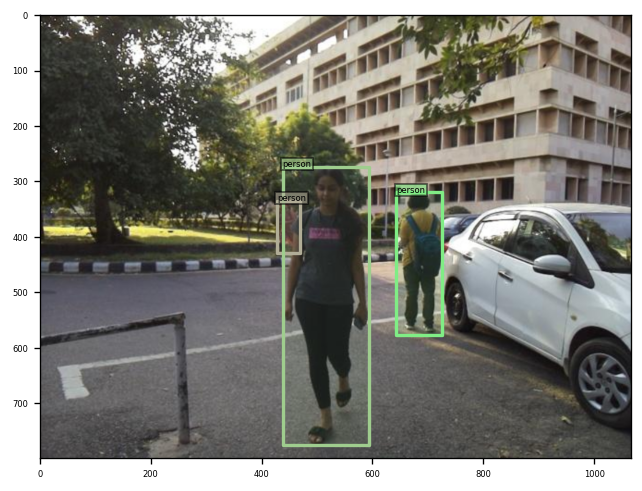

In [20]:
# build gt_dict for vis
box_label = [id2name[int(item)] for item in targets['labels']]
gt_dict = {
    'boxes': targets['boxes'],
    'image_id': targets['image_id'],
    'size': targets['size'],
    'box_label': box_label,
}
print("Image id is: ", targets['image_id'])
vslzr = COCOVisualizer()
vslzr.visualize(image, gt_dict, savedir=None)

# Visualizing model predictions for the above Image

In [11]:
model_config_path = "/content/drive/MyDrive/Delhi/DINO/config/DINO/DINO_4scale.py" # change the path of the model config file
model_checkpoint_path = "/content/drive/MyDrive/Delhi/checkpoints/checkpoint0033_4scale.pth" # change the path of the model checkpoint

args = SLConfig.fromfile(model_config_path)
args.device = 'cuda'
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

NameError: ignored

In [21]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [22]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold
print(id2name)

{1: 'person', 2: 'bicycle', 3: 'car', 4: 'motorcycle', 5: 'airplane', 6: 'bus', 7: 'train', 8: 'truck', 9: 'boat', 10: 'traffic light', 11: 'fire hydrant', 13: 'stop sign', 14: 'parking meter', 15: 'bench', 16: 'bird', 17: 'cat', 18: 'dog', 19: 'horse', 20: 'sheep', 21: 'cow', 22: 'elephant', 23: 'bear', 24: 'zebra', 25: 'giraffe', 27: 'backpack', 28: 'umbrella', 31: 'handbag', 32: 'tie', 33: 'suitcase', 34: 'frisbee', 35: 'skis', 36: 'snowboard', 37: 'sports ball', 38: 'kite', 39: 'baseball bat', 40: 'baseball glove', 41: 'skateboard', 42: 'surfboard', 43: 'tennis racket', 44: 'bottle', 46: 'wine glass', 47: 'cup', 48: 'fork', 49: 'knife', 50: 'spoon', 51: 'bowl', 52: 'banana', 53: 'apple', 54: 'sandwich', 55: 'orange', 56: 'broccoli', 57: 'carrot', 58: 'hot dog', 59: 'pizza', 60: 'donut', 61: 'cake', 62: 'chair', 63: 'couch', 64: 'potted plant', 65: 'bed', 67: 'dining table', 70: 'toilet', 72: 'tv', 73: 'laptop', 74: 'mouse', 75: 'remote', 76: 'keyboard', 77: 'cell phone', 78: 'micro

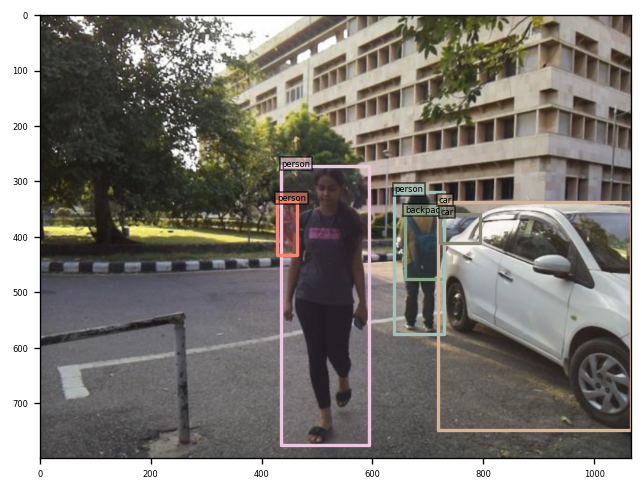

In [23]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# Running validation data on pretrained model

In [24]:
os.chdir("/content/drive/MyDrive/Delhi/DINO")
!pwd

/content/drive/MyDrive/Delhi/DINO


In [25]:
!bash scripts/DINO_eval.sh /content/drive/MyDrive/Delhi/dino_dataset/ /content/drive/MyDrive/Delhi/checkpoints/checkpoint0033_4scale.pth

dataset file is delhi
Not using distributed mode
Loading config file from config/DINO/DINO_4scale.py
[11/27 13:29:05.151]: git:
  sha: 69f0d5e3c8d8cbb6c0f4ed7bc1f518a8bfb8f8b2, status: has uncommited changes, branch: main

[11/27 13:29:05.541]: Command: main.py --output_dir logs/DINO/R50-MS4-%j -c config/DINO/DINO_4scale.py --coco_path /content/drive/MyDrive/Delhi/dino_dataset/ --eval --resume /content/drive/MyDrive/Delhi/checkpoints/checkpoint0033_4scale.pth --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0
[11/27 13:29:05.772]: Full config saved to logs/DINO/R50-MS4-%j/config_args_all.json
[11/27 13:29:05.772]: world size: 1
[11/27 13:29:05.773]: rank: 0
[11/27 13:29:05.773]: local_rank: 0
[11/27 13:29:05.774]: args: Namespace(config_file='config/DINO/DINO_4scale.py', options={'dn_scalar': 100, 'embed_init_tgt': True, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'use_ema': False, 'dn_box_noise_scale': 1.0}, dataset_file=

# Visualizing model predictions for a new Image

In [31]:
image, targets = dataset_val[1]

In [32]:
image.shape, image[None].shape

(torch.Size([3, 800, 1066]), torch.Size([1, 3, 800, 1066]))

In [33]:
output = model.cuda()(image[None].cuda())
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

In [34]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold

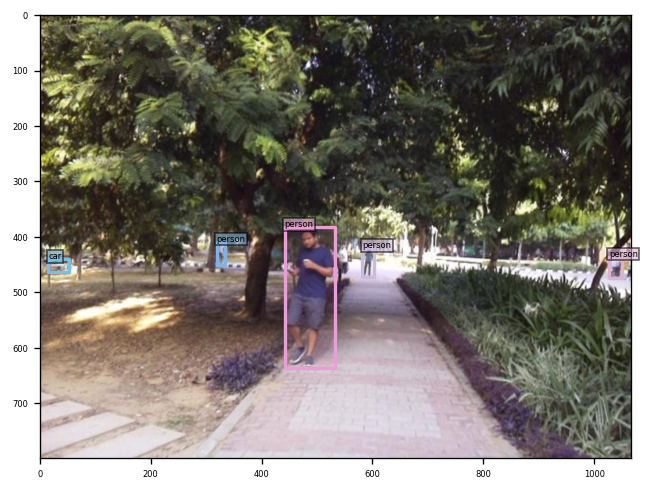

In [35]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# Visualization of output after each decoder layer

In [36]:
def visualize_layerk(k):
    output = model.layer_output(k)
    print(output)
    output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]
    thershold = 0.2 # set a thershold
    scores = output['scores']
    labels = output['labels']
    boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
    select_mask = scores > thershold
    box_label = [id2name[int(item)] for item in labels[select_mask]]
    pred_dict = {
        'boxes': boxes[select_mask],
        'size': targets['size'],
        'box_label': box_label
    }
    vslzr.visualize(image, pred_dict, savedir=None)

{'pred_logits': tensor([[[-10.6930,   2.4669,  -5.2070,  ...,  -6.4200,  -7.4165,  -7.9882],
         [ -9.9143,   1.6936,  -4.3090,  ...,  -5.7118,  -5.6703,  -6.7384],
         [ -8.8796,  -0.5656,  -4.3716,  ...,  -5.3541,  -6.4053,  -7.7779],
         ...,
         [ -9.1867,  -4.6108,  -5.1063,  ...,  -6.6475,  -7.3881,  -7.7254],
         [ -9.8752,  -4.5280,  -5.7814,  ...,  -7.5005,  -8.3045,  -7.7084],
         [ -9.4537,  -5.6352,  -6.3297,  ...,  -7.6698,  -9.1658,  -7.0120]]],
       device='cuda:0', grad_fn=<SelectBackward0>), 'pred_boxes': tensor([[[0.4571, 0.6368, 0.0866, 0.3179],
         [0.5554, 0.5576, 0.0194, 0.0658],
         [0.9735, 0.5685, 0.0220, 0.0491],
         ...,
         [0.9724, 0.5763, 0.0208, 0.0352],
         [0.9893, 0.5488, 0.0138, 0.0950],
         [0.0823, 0.9451, 0.1622, 0.0982]]], device='cuda:0',
       grad_fn=<SelectBackward0>)}


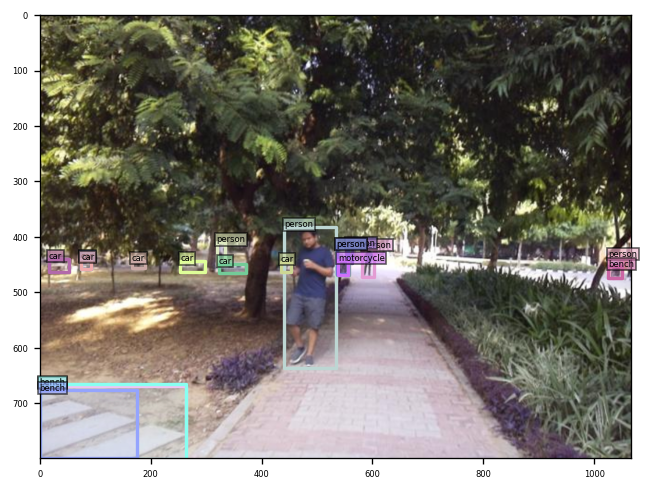

In [37]:
visualize_layerk(0)

{'pred_logits': tensor([[[-10.7814,   2.8641,  -6.3745,  ...,  -6.8082,  -8.5337,  -8.2229],
         [-10.1865,   2.0381,  -5.5063,  ...,  -6.3485,  -7.4366,  -7.3856],
         [ -8.6706,  -0.4344,  -4.5799,  ...,  -5.0864,  -7.1418,  -7.1397],
         ...,
         [ -8.4734,  -5.8691,  -5.6361,  ...,  -7.4176,  -7.9760,  -7.8981],
         [-10.1303,  -4.2257,  -5.5690,  ...,  -7.4406,  -8.6620,  -7.6595],
         [ -8.5708,  -6.3637,  -6.7512,  ...,  -7.5900,  -8.4017,  -7.1381]]],
       device='cuda:0', grad_fn=<SelectBackward0>), 'pred_boxes': tensor([[[0.4573, 0.6369, 0.0867, 0.3183],
         [0.5553, 0.5576, 0.0192, 0.0658],
         [0.9736, 0.5686, 0.0221, 0.0492],
         ...,
         [0.9718, 0.5776, 0.0236, 0.0317],
         [0.9911, 0.5562, 0.0153, 0.0865],
         [0.0809, 0.9442, 0.1602, 0.0992]]], device='cuda:0',
       grad_fn=<SelectBackward0>)}


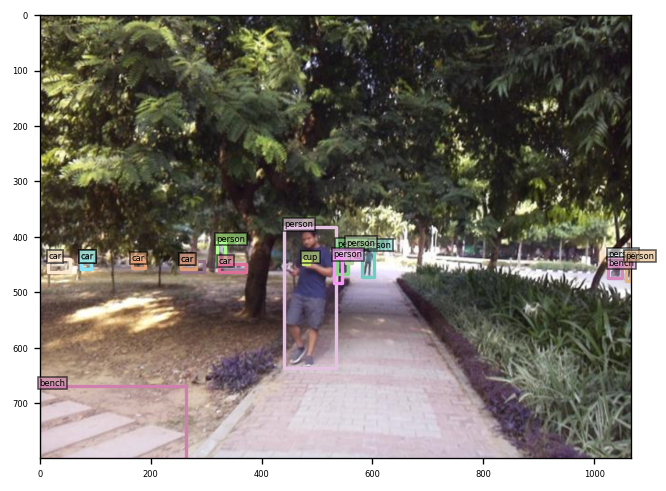

In [38]:
visualize_layerk(1)

{'pred_logits': tensor([[[-10.3390,   2.5746,  -6.4900,  ...,  -6.6915,  -7.7061,  -7.8221],
         [ -9.8023,   1.9270,  -5.9135,  ...,  -6.1404,  -6.6473,  -6.8443],
         [ -9.6619,  -0.4793,  -4.4369,  ...,  -5.2768,  -6.8176,  -6.3996],
         ...,
         [-10.1412,  -6.3180,  -5.7335,  ...,  -8.0276,  -8.3123,  -8.6778],
         [-10.2860,  -4.3467,  -5.9398,  ...,  -7.7448,  -8.8275,  -7.6051],
         [ -9.0747,  -6.9520,  -7.0944,  ...,  -7.8804,  -7.6395,  -7.5162]]],
       device='cuda:0', grad_fn=<SelectBackward0>), 'pred_boxes': tensor([[[0.4571, 0.6372, 0.0859, 0.3186],
         [0.5552, 0.5577, 0.0190, 0.0659],
         [0.9737, 0.5690, 0.0219, 0.0495],
         ...,
         [0.9727, 0.5793, 0.0246, 0.0278],
         [0.9945, 0.5559, 0.0117, 0.1002],
         [0.0883, 0.9359, 0.1445, 0.0814]]], device='cuda:0',
       grad_fn=<SelectBackward0>)}


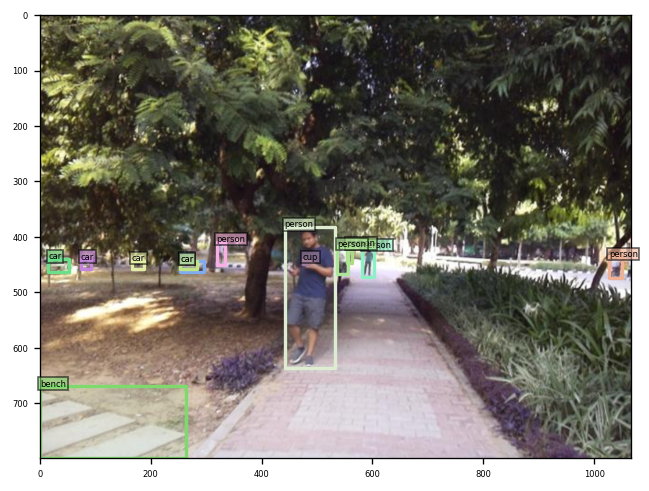

In [39]:
visualize_layerk(3)

{'pred_logits': tensor([[[-10.0248,   2.4525,  -6.1290,  ...,  -6.2688,  -6.7147,  -7.3977],
         [ -9.5204,   1.8950,  -5.0455,  ...,  -5.8548,  -6.2469,  -6.4416],
         [ -9.8129,  -0.5191,  -4.3025,  ...,  -5.3832,  -6.9030,  -6.5037],
         ...,
         [ -8.9286,  -7.6119,  -7.0255,  ...,  -8.3865,  -7.8736,  -7.8413],
         [-10.0257,  -4.9524,  -6.5873,  ...,  -7.6450,  -8.4864,  -7.6908],
         [ -9.3114,  -6.9179,  -6.9277,  ...,  -7.9089,  -8.6049,  -7.3162]]],
       device='cuda:0', grad_fn=<SelectBackward0>), 'pred_boxes': tensor([[[0.4571, 0.6371, 0.0858, 0.3186],
         [0.5552, 0.5577, 0.0190, 0.0659],
         [0.9737, 0.5690, 0.0219, 0.0497],
         ...,
         [0.9731, 0.5805, 0.0215, 0.0224],
         [0.9946, 0.5508, 0.0115, 0.0997],
         [0.0824, 0.9338, 0.1554, 0.0812]]], device='cuda:0',
       grad_fn=<SelectBackward0>)}


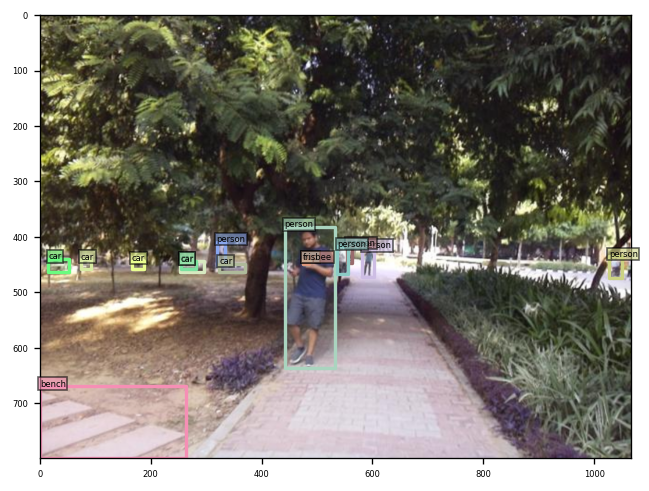

In [40]:
visualize_layerk(4)

{'pred_logits': tensor([[[-10.6204,   2.6090,  -6.9569,  ...,  -6.3549,  -7.6301,  -7.8500],
         [-10.5754,   1.9339,  -5.6937,  ...,  -6.2554,  -7.5294,  -7.0900],
         [-10.2148,  -0.4051,  -4.3290,  ...,  -5.1833,  -7.3451,  -6.7873],
         ...,
         [ -9.2171,  -7.6281,  -7.4639,  ...,  -8.7270,  -8.6984,  -8.2683],
         [ -9.2675,  -5.3104,  -6.8264,  ...,  -7.9168,  -8.6115,  -7.5126],
         [ -9.0906,  -7.8261,  -7.4167,  ...,  -8.9327,  -9.5030,  -8.1641]]],
       device='cuda:0', grad_fn=<SelectBackward0>), 'pred_boxes': tensor([[[0.4571, 0.6371, 0.0859, 0.3185],
         [0.5552, 0.5577, 0.0190, 0.0659],
         [0.9737, 0.5691, 0.0219, 0.0496],
         ...,
         [0.9734, 0.5806, 0.0214, 0.0223],
         [0.9944, 0.5528, 0.0117, 0.0964],
         [0.0823, 0.9349, 0.1558, 0.0830]]], device='cuda:0',
       grad_fn=<SelectBackward0>)}


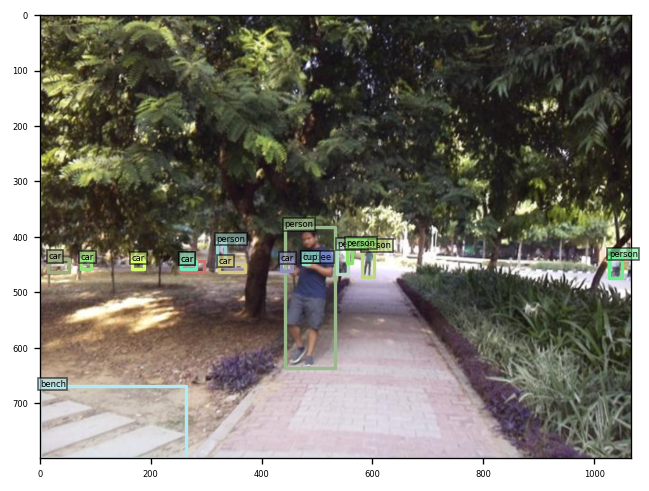

In [41]:
visualize_layerk(5)

# Visualizing sampling points for the best query

In [10]:
os.chdir('/content/drive/MyDrive/Delhi/DINO')
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

model_config_path = "/content/drive/MyDrive/Delhi/DINO/config/DINO/DINO_4scale.py" # change the path of the model config file
model_checkpoint_path = "/content/drive/MyDrive/Delhi/checkpoints/checkpoint0033_4scale.pth" # change the path of the model checkpoint

args = SLConfig.fromfile(model_config_path)
args.device = 'cuda'
model, criterion, postprocessors = build_model_main(args)
checkpoint = torch.load(model_checkpoint_path, map_location='cpu')
model.load_state_dict(checkpoint['model'])
_ = model.eval()

args.dataset_file = 'delhi'
args.coco_path = "/content/drive/MyDrive/Delhi/dino_dataset/" # the path of coco
args.fix_size = False
dataset_val = build_dataset(image_set='val', args=args)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [11]:
image, _ = dataset_val[2]
output = model.cuda()(image[None].cuda())
# breakpoint()
output = postprocessors['bbox'](output, torch.Tensor([[1.0, 1.0]]).cuda())[0]

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]

PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 336, in set_trace
    sys.settrace(self.trace_dispatch)



> /content/drive/MyDrive/Delhi/DINO/models/dino/deformable_transformer.py(578)forward()
    576 
    577         breakpoint()
--> 578         return output, intermediate_output, intermediate_ref
    579 
    580 class TransformerDecoder(nn.Module):

ipdb> p intermediate_output
None
ipdb> p output
tensor([[[-0.1740,  0.6208,  1.3863,  ..., -0.6375,  0.2214, -0.0280],
         [ 0.2280,  0.9036,  1.5108,  ..., -0.5476,  0.4868, -0.0965],
         [ 0.2945,  1.0310,  1.4272,  ..., -0.3643,  0.7389, -0.3912],
         ...,
         [-0.1652, -0.1457,  0.4229,  ..., -0.4183, -0.4062,  0.2723],
         [-0.2803, -0.1256,  0.4658,  ..., -0.4889, -0.5403,  0.2484],
         [-0.3873, -0.1521,  0.4966,  ..., -0.6482, -0.6593,  0.2832]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)
ipdb> p output.shape
torch.Size([1, 17821, 256])
ipdb> p intermediate_reff
*** NameError: name 'intermediate_reff' is not defined
ipdb> p intermediate_ref
None
ipdb> 



PYDEV DEBUGGER WARNING:
sys.settrace() should not be used when the debugger is being used.
This may cause the debugger to stop working correctly.
If this is needed, please check: 
http://pydev.blogspot.com/2007/06/why-cant-pydev-debugger-work-with.html
to see how to restore the debug tracing back correctly.
Call Location:
  File "/usr/lib/python3.10/bdb.py", line 361, in set_quit
    sys.settrace(None)



In [ ]:
thershold = 0.3 # set a thershold

scores = output['scores']
labels = output['labels']
boxes = box_ops.box_xyxy_to_cxcywh(output['boxes'])
select_mask = scores > thershold
print(id2name)

In [ ]:
box_label = [id2name[int(item)] for item in labels[select_mask]]
pred_dict = {
    'boxes': boxes[select_mask],
    'size': targets['size'],
    'box_label': box_label
}
vslzr.visualize(image, pred_dict, savedir=None)

# Finetuning the DINO model with 91 classes

In [74]:
os.chdir('/content/drive/MyDrive/Delhi/dino_dataset/train/')
import xmltodict
import json

def create_targetjson(xmlfiles):
    idx = 0
    cat_idx = 0
    annot_idx = 0
    licenses = [{
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License"
        }]
    images = []
    annots = []
    categories = []
    unique_cat = set()
    for file in xmlfiles:
        with open(file, 'r') as xml_file:
            xml_content = xml_file.read()
        xml_dict = xmltodict.parse(xml_content)
        image_id = idx + 1
        idx += 1
        images.append({
            "license": 1,
            "file_name": file.replace(".xml",".png"),
            "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
            "height": xml_dict['annotation']['size']['height'],
            "width": xml_dict['annotation']['size']['width'],
            "date_captured": "2013-11-14 17:02:52",
            "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
            "id": image_id
        })
        for key, value in xml_dict['annotation'].items():
            if key == "object":
                if not isinstance(value,list):
                    value = [value]
                for val in value:
                    # breakpoint()
                    if val["name"] not in unique_cat:
                        unique_cat.add(val["name"])
                        categories.append({
                            "supercategory": val["name"],
                            "id": cat_idx + 1,
                            "name": val["name"],
                            "keypoints": [],
                            "skeleton": []
                        })
                        cat_idx += 1
                    width = int(val["bndbox"]["xmax"]) - int(val["bndbox"]["xmin"])
                    height = int(val["bndbox"]["ymax"]) - int(val["bndbox"]["ymin"])
                    annots.append({
                        "segmentation": [],
                        "num_keypoints": 0,
                        "area": 0,
                        "iscrowd": 0,
                        "keypoints":[],
                        "image_id": image_id,
                        "bbox": [int(val["bndbox"]["xmin"]),int(val["bndbox"]["ymin"]), width, height],
                        "category_id": 1,
                        "id": annot_idx + 1
                    })
                    annot_idx += 1
    target_data = {"info": {
            "description": "COCO 2017 Dataset",
            "url": "http://cocodataset.org",
            "version": "1.0",
            "year": 2017,
            "contributor": "COCO Consortium",
            "date_created": "2017/09/01"
        }, "licenses":licenses, "images":images, "annotations":annots, "categories":categories}
    print(f"unique cat {unique_cat}")
    return target_data

In [75]:
current_directory = os.getcwd()
files_in_directory = os.listdir(current_directory)
xml_files = [file for file in files_in_directory if file.endswith('.xml')]
# xml_files  = ['Image_00136.xml', 'Image_00140.xml']
target_data = create_targetjson(xml_files)
with open("target.json",'w') as fi:
    json.dump(target_data,fi)
# target_data

unique cat {'pedestrian'}


In [ ]:
os.chdir('/content/drive/MyDrive/Delhi/DINO')
!bash scripts/DINO_train.sh /content/drive/MyDrive/Delhi/dino_dataset/

In [ ]:
!bash scripts/DINO_eval.sh /content/drive/MyDrive/Delhi/dino_dataset/ /content/drive/MyDrive/Delhi/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth

# Finetuning the DINO model on pretrained checkpoint with 91 classes

In [18]:
os.chdir('/content/drive/MyDrive/Delhi/dino_dataset/train/')
import xmltodict
import json

def create_targetjson(xmlfiles):
    idx = 0
    cat_idx = 0
    annot_idx = 0
    licenses = [{
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License"
        }]
    images = []
    annots = []
    categories = []
    unique_cat = set()
    for file in xmlfiles:
        with open(file, 'r') as xml_file:
            xml_content = xml_file.read()
        xml_dict = xmltodict.parse(xml_content)
        image_id = idx + 1
        idx += 1
        images.append({
            "license": 1,
            "file_name": file.replace(".xml",".png"),
            "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
            "height": xml_dict['annotation']['size']['height'],
            "width": xml_dict['annotation']['size']['width'],
            "date_captured": "2013-11-14 17:02:52",
            "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
            "id": image_id
        })
        for key, value in xml_dict['annotation'].items():
            if key == "object":
                if not isinstance(value,list):
                    value = [value]
                for val in value:
                    # breakpoint()
                    if val["name"] not in unique_cat:
                        unique_cat.add(val["name"])
                        categories.append({
                            "supercategory": val["name"],
                            "id": cat_idx + 1,
                            "name": val["name"],
                            "keypoints": [],
                            "skeleton": []
                        })
                        cat_idx += 1
                    width = int(val["bndbox"]["xmax"]) - int(val["bndbox"]["xmin"])
                    height = int(val["bndbox"]["ymax"]) - int(val["bndbox"]["ymin"])
                    annots.append({
                        "segmentation": [],
                        "num_keypoints": 0,
                        "area": 0,
                        "iscrowd": 0,
                        "keypoints":[],
                        "image_id": image_id,
                        "bbox": [int(val["bndbox"]["xmin"]),int(val["bndbox"]["ymin"]), width, height],
                        "category_id": 1,
                        "id": annot_idx + 1
                    })
                    annot_idx += 1
    target_data = {"info": {
            "description": "COCO 2017 Dataset",
            "url": "http://cocodataset.org",
            "version": "1.0",
            "year": 2017,
            "contributor": "COCO Consortium",
            "date_created": "2017/09/01"
        }, "licenses":licenses, "images":images, "annotations":annots, "categories":categories}
    print(f"unique cat {unique_cat}")
    return target_data

In [19]:
current_directory = os.getcwd()
files_in_directory = os.listdir(current_directory)
xml_files = [file for file in files_in_directory if file.endswith('.xml')]
# xml_files  = ['Image_00136.xml', 'Image_00140.xml']
target_data = create_targetjson(xml_files)
with open("target.json",'w') as fi:
    json.dump(target_data,fi)
# target_data

unique cat {'pedestrian'}


In [25]:
os.chdir('/content/drive/MyDrive/Delhi/DINO')
!bash scripts/DINO_finetune_checkpt.sh /content/drive/MyDrive/Delhi/dino_dataset/

dataset file is delhi
Not using distributed mode
Loading config file from config/DINO/DINO_4scale.py
[11/27 18:57:01.875]: git:
  sha: 69f0d5e3c8d8cbb6c0f4ed7bc1f518a8bfb8f8b2, status: has uncommited changes, branch: main

[11/27 18:57:01.875]: Command: main.py --output_dir logs/DINO/R50-MS4 -c config/DINO/DINO_4scale.py --coco_path /content/drive/MyDrive/Delhi/dino_dataset/ --options dn_scalar=100 embed_init_tgt=TRUE --pretrain_model_path /content/drive/MyDrive/Delhi/checkpoints/checkpoint0033_4scale.pth --finetune_ignore label_enc.weight class_embed dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0
[11/27 18:57:01.879]: Full config saved to logs/DINO/R50-MS4/config_args_all.json
[11/27 18:57:01.879]: world size: 1
[11/27 18:57:01.880]: rank: 0
[11/27 18:57:01.880]: local_rank: 0
[11/27 18:57:01.880]: args: Namespace(config_file='config/DINO/DINO_4scale.py', options={'dn_scalar': 100, 'embed_init_tgt': True}, dataset_file='delhi', coco_path='/content/drive/MyDriv

In [26]:
!bash scripts/DINO_eval.sh /content/drive/MyDrive/Delhi/dino_dataset/ /content/drive/MyDrive/Delhi/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth

dataset file is delhi
Not using distributed mode
Loading config file from config/DINO/DINO_4scale.py
[11/27 19:04:30.936]: git:
  sha: 69f0d5e3c8d8cbb6c0f4ed7bc1f518a8bfb8f8b2, status: has uncommited changes, branch: main

[11/27 19:04:30.939]: Command: main.py --output_dir logs/DINO/R50-MS4-%j -c config/DINO/DINO_4scale.py --coco_path /content/drive/MyDrive/Delhi/dino_dataset/ --eval --resume /content/drive/MyDrive/Delhi/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth --options dn_scalar=100 embed_init_tgt=TRUE dn_label_coef=1.0 dn_bbox_coef=1.0 use_ema=False dn_box_noise_scale=1.0
[11/27 19:04:30.943]: Full config saved to logs/DINO/R50-MS4-%j/config_args_all.json
[11/27 19:04:30.944]: world size: 1
[11/27 19:04:30.944]: rank: 0
[11/27 19:04:30.945]: local_rank: 0
[11/27 19:04:30.946]: args: Namespace(config_file='config/DINO/DINO_4scale.py', options={'dn_scalar': 100, 'embed_init_tgt': True, 'dn_label_coef': 1.0, 'dn_bbox_coef': 1.0, 'use_ema': False, 'dn_box_noise_scale': 1.0}, 

# Training the DINO model from scratch for just one class

In [27]:
os.chdir('/content/drive/MyDrive/Delhi/DINO')
import os, sys
import torch, json
import numpy as np

from main import build_model_main
from util.slconfig import SLConfig
from datasets import build_dataset
from util.visualizer import COCOVisualizer
from util import box_ops

model_config_path = "/content/drive/MyDrive/Delhi/DINO/config/DINO/DINO_4scaleD.py" # change the path of the model config file
model_checkpoint_path = "/content/drive/MyDrive/Delhi/checkpoints/checkpoint0033_4scale.pth" # change the path of the model checkpoint

args = SLConfig.fromfile(model_config_path)
args.device = 'cuda'

args.dataset_file = 'delhi'
args.coco_path = "/content/drive/MyDrive/Delhi/dino_dataset/" # the path of coco
args.fix_size = False
dataset_val = build_dataset(image_set='val', args=args)

data_aug_params: {
  "scales": [
    480,
    512,
    544,
    576,
    608,
    640,
    672,
    704,
    736,
    768,
    800
  ],
  "max_size": 1333,
  "scales2_resize": [
    400,
    500,
    600
  ],
  "scales2_crop": [
    384,
    600
  ]
}
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [28]:
os.chdir('/content/drive/MyDrive/Delhi/dino_dataset/train/')
import xmltodict
import json

def create_targetjson(xmlfiles):
    idx = 0
    cat_idx = 0
    annot_idx = 0
    licenses = [{
            "url": "http://creativecommons.org/licenses/by-nc-sa/2.0/",
            "id": 1,
            "name": "Attribution-NonCommercial-ShareAlike License"
        }]
    images = []
    annots = []
    categories = []
    unique_cat = set()
    for file in xmlfiles:
        with open(file, 'r') as xml_file:
            xml_content = xml_file.read()
        xml_dict = xmltodict.parse(xml_content)
        image_id = idx + 1
        idx += 1
        images.append({
            "license": 1,
            "file_name": file.replace(".xml",".png"),
            "coco_url": "http://images.cocodataset.org/val2017/000000397133.jpg",
            "height": xml_dict['annotation']['size']['height'],
            "width": xml_dict['annotation']['size']['width'],
            "date_captured": "2013-11-14 17:02:52",
            "flickr_url": "http://farm7.staticflickr.com/6116/6255196340_da26cf2c9e_z.jpg",
            "id": image_id
        })
        for key, value in xml_dict['annotation'].items():
            if key == "object":
                if not isinstance(value,list):
                    value = [value]
                for val in value:
                    # breakpoint()
                    if val["name"] not in unique_cat:
                        unique_cat.add(val["name"])
                        categories.append({
                            "supercategory": val["name"],
                            "id": cat_idx + 1,
                            "name": val["name"],
                            "keypoints": [],
                            "skeleton": []
                        })
                        cat_idx += 1
                    width = int(val["bndbox"]["xmax"]) - int(val["bndbox"]["xmin"])
                    height = int(val["bndbox"]["ymax"]) - int(val["bndbox"]["ymin"])
                    annots.append({
                        "segmentation": [],
                        "num_keypoints": 0,
                        "area": 0,
                        "iscrowd": 0,
                        "keypoints":[],
                        "image_id": image_id,
                        "bbox": [int(val["bndbox"]["xmin"]),int(val["bndbox"]["ymin"]), width, height],
                        "category_id": 1,
                        "id": annot_idx + 1
                    })
                    annot_idx += 1
    target_data = {"info": {
            "description": "COCO 2017 Dataset",
            "url": "http://cocodataset.org",
            "version": "1.0",
            "year": 2017,
            "contributor": "COCO Consortium",
            "date_created": "2017/09/01"
        }, "licenses":licenses, "images":images, "annotations":annots, "categories":categories}
    print(f"unique cat {unique_cat}")
    return target_data

In [29]:
current_directory = os.getcwd()
files_in_directory = os.listdir(current_directory)
xml_files = [file for file in files_in_directory if file.endswith('.xml')]
# xml_files  = ['Image_00136.xml', 'Image_00140.xml']
target_data = create_targetjson(xml_files)
with open("target.json",'w') as fi:
    json.dump(target_data,fi)
# target_data

unique cat {'pedestrian'}


In [33]:
# load coco names
os.chdir('/content/drive/MyDrive/Delhi/DINO/util/')
with open('iitd_id2name.json') as f:
    id2name = json.load(f)
    id2name = {int(k):v for k,v in id2name.items()}
id2name

{1: 'pedestrain'}

In [ ]:
os.chdir('/content/drive/MyDrive/Delhi/DINO')
!bash scripts/DINO_scratch_train.sh /content/drive/MyDrive/Delhi/dino_dataset/

In [ ]:
!bash scripts/DINO_eval.sh /content/drive/MyDrive/Delhi/dino_dataset/ /content/drive/MyDrive/Delhi/DINO/logs/DINO/R50-MS4/checkpoint_best_regular.pth